In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats as stats
import pandas_profiling 

import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

import statsmodels.formula.api as sm


from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

from sklearn.metrics import roc_curve, auc


In [2]:
### Notebook configuration settings
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 1000
pd.options.display.float_format = '{:.3f}'.format
import warnings
warnings.filterwarnings('ignore')

In [3]:
writer=pd.ExcelWriter('network_intrusion_binomial_clsfn.xlsx', engine='xlsxwriter')

### Importing network data from file

In [4]:

network_data=pd.read_csv('NSL_Dataset\Train.txt',sep=',',header=None)

In [5]:
BASIC_FEATURES=['DURATION','PROTOCOL_TYPE','SERVICE','FLAG','SRC_BYTES','DST_BYTES','LAND','WRONG_FRAGMENT','URGENT']

In [6]:
CONTENT_FEATURES =['HOT','NUM_FAILED_LOGINS','LOGGED_IN','NUM_COMPROMISED','ROOT_SHELL','SU_ATTEMPTED','NUM_ROOT','NUM_FILE_CREATIONS','NUM_SHELLS','NUM_ACCESS_FILES','NUM_OUTBOUND_CMDS','IS_HOST_LOGIN','IS_GUEST_LOGIN']

In [7]:
TIME_FEATURES=['COUNT','SRV_COUNT','SERROR_RATE','SRV_SERROR_RATE','RERROR_RATE','SRV_RERROR_RATE','SAME_SRV_RATE','DIFF_SRV_RATE','SRV_DIFF_HOST_RATE']

In [8]:
HOST_FEATURES=['DST_HOST_COUNT','DST_HOST_SRV_COUNT','DST_HOST_SAME_SRV_RATE','DST_HOST_DIFF_SRV_RATE','DST_HOST_SAME_SRC_PORT_RATE','DST_HOST_SRV_DIFF_HOST_RATE','DST_HOST_SERROR_RATE','DST_HOST_SRV_SERROR_RATE','DST_HOST_RERROR_RATE','DST_HOST_SRV_RERROR_RATE']

In [9]:
OTHER_FEATURES=['ATTACK','LAST_FLAG']

In [10]:
total_features=BASIC_FEATURES+CONTENT_FEATURES+TIME_FEATURES+HOST_FEATURES+OTHER_FEATURES

In [11]:
total_features

['DURATION',
 'PROTOCOL_TYPE',
 'SERVICE',
 'FLAG',
 'SRC_BYTES',
 'DST_BYTES',
 'LAND',
 'WRONG_FRAGMENT',
 'URGENT',
 'HOT',
 'NUM_FAILED_LOGINS',
 'LOGGED_IN',
 'NUM_COMPROMISED',
 'ROOT_SHELL',
 'SU_ATTEMPTED',
 'NUM_ROOT',
 'NUM_FILE_CREATIONS',
 'NUM_SHELLS',
 'NUM_ACCESS_FILES',
 'NUM_OUTBOUND_CMDS',
 'IS_HOST_LOGIN',
 'IS_GUEST_LOGIN',
 'COUNT',
 'SRV_COUNT',
 'SERROR_RATE',
 'SRV_SERROR_RATE',
 'RERROR_RATE',
 'SRV_RERROR_RATE',
 'SAME_SRV_RATE',
 'DIFF_SRV_RATE',
 'SRV_DIFF_HOST_RATE',
 'DST_HOST_COUNT',
 'DST_HOST_SRV_COUNT',
 'DST_HOST_SAME_SRV_RATE',
 'DST_HOST_DIFF_SRV_RATE',
 'DST_HOST_SAME_SRC_PORT_RATE',
 'DST_HOST_SRV_DIFF_HOST_RATE',
 'DST_HOST_SERROR_RATE',
 'DST_HOST_SRV_SERROR_RATE',
 'DST_HOST_RERROR_RATE',
 'DST_HOST_SRV_RERROR_RATE',
 'ATTACK',
 'LAST_FLAG']

In [12]:
network_data.columns=total_features

In [13]:
network_data.shape

(125973, 43)

In [14]:
network_data.head()

,DURATION,PROTOCOL_TYPE,SERVICE,FLAG,SRC_BYTES,DST_BYTES,LAND,WRONG_FRAGMENT,URGENT,HOT,NUM_FAILED_LOGINS,LOGGED_IN,NUM_COMPROMISED,ROOT_SHELL,SU_ATTEMPTED,NUM_ROOT,NUM_FILE_CREATIONS,NUM_SHELLS,NUM_ACCESS_FILES,NUM_OUTBOUND_CMDS,IS_HOST_LOGIN,IS_GUEST_LOGIN,COUNT,SRV_COUNT,SERROR_RATE,SRV_SERROR_RATE,RERROR_RATE,SRV_RERROR_RATE,SAME_SRV_RATE,DIFF_SRV_RATE,SRV_DIFF_HOST_RATE,DST_HOST_COUNT,DST_HOST_SRV_COUNT,DST_HOST_SAME_SRV_RATE,DST_HOST_DIFF_SRV_RATE,DST_HOST_SAME_SRC_PORT_RATE,DST_HOST_SRV_DIFF_HOST_RATE,DST_HOST_SERROR_RATE,DST_HOST_SRV_SERROR_RATE,DST_HOST_RERROR_RATE,DST_HOST_SRV_RERROR_RATE,ATTACK,LAST_FLAG
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.000,0.000,0.000,0.000,1.000,0.000,0.000,150,25,0.170,0.030,0.170,0.000,0.000,0.000,0.050,0.000,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.000,0.000,0.000,0.000,0.080,0.150,0.000,255,1,0.000,0.600,0.880,0.000,0.000,0.000,0.000,0.000,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.000,1.000,0.000,0.000,0.050,0.070,0.000,255,26,0.100,0.050,0.000,0.000,1.000,1.000,0.000,0.000,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.200,0.200,0.000,0.000,1.000,0.000,0.000,30,255,1.000,0.000,0.030,0.040,0.030,0.010,0.000,0.010,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.000,0.000,0.000,0.000,1.000,0.000,0.090,255,255,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,normal,21


### Creation of user defined functions

In [15]:
## function to remove column from categorical and numerical features
def remove_columns_from_list(col):
        if col in categorical:
            categorical.remove(col)
        elif col in numerical:
            numerical.remove(col)
        else:
            print("Variable not present in both the list")

In [16]:
def remove_columns_from_main_set(col):
    network_data.drop(col,axis=1,inplace=True)
    

In [17]:
def missing_treatment(col):
    if col in categorical:
        network_data[col].fillna(network_data[col].mode()[0],inplace=True)
    elif col in numerical:
        network_data[col].fillna(network_data[col].median(),inplace=True)
    else:
        print("Variable not present in both the list")
        
    

In [18]:
def cont_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), round(x.sum(),2), round(x.mean(),2), round(x.median(),2),  round(x.std(),2), round(x.var(),2), round((x.std()/x.mean()),2), round(x.min(),2), round(x.dropna().quantile(0.01),2), round(x.dropna().quantile(0.05),2),round(x.dropna().quantile(0.10),2),round(x.dropna().quantile(0.25),2),round(x.dropna().quantile(0.50),2),round(x.dropna().quantile(0.75),2), round(x.dropna().quantile(0.90),2),round(x.dropna().quantile(0.95),2), round(x.dropna().quantile(0.99),2),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'CV','MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

def cat_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [19]:
dummy_var=[]
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname, drop_first=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    for col1 in col_dummies:
         dummy_var.append(col1)
    return df


### Exploratary data analysis

In [20]:
network_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
DURATION                       125973 non-null int64
PROTOCOL_TYPE                  125973 non-null object
SERVICE                        125973 non-null object
FLAG                           125973 non-null object
SRC_BYTES                      125973 non-null int64
DST_BYTES                      125973 non-null int64
LAND                           125973 non-null int64
WRONG_FRAGMENT                 125973 non-null int64
URGENT                         125973 non-null int64
HOT                            125973 non-null int64
NUM_FAILED_LOGINS              125973 non-null int64
LOGGED_IN                      125973 non-null int64
NUM_COMPROMISED                125973 non-null int64
ROOT_SHELL                     125973 non-null int64
SU_ATTEMPTED                   125973 non-null int64
NUM_ROOT                       125973 non-null int64
NUM_FILE_CREATIONS             125973 

In [21]:
numerical=[key for key in dict(network_data.dtypes) if dict(network_data.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
categorical=[key for key in dict(network_data.dtypes) if dict(network_data.dtypes)[key] in ['object']]
print(f"Numerical variables : \n \n {numerical} \n")
print(f"Categorical variables : \n \n {categorical} \n")

Numerical variables : 
 
 ['DURATION', 'SRC_BYTES', 'DST_BYTES', 'LAND', 'WRONG_FRAGMENT', 'URGENT', 'HOT', 'NUM_FAILED_LOGINS', 'LOGGED_IN', 'NUM_COMPROMISED', 'ROOT_SHELL', 'SU_ATTEMPTED', 'NUM_ROOT', 'NUM_FILE_CREATIONS', 'NUM_SHELLS', 'NUM_ACCESS_FILES', 'NUM_OUTBOUND_CMDS', 'IS_HOST_LOGIN', 'IS_GUEST_LOGIN', 'COUNT', 'SRV_COUNT', 'SERROR_RATE', 'SRV_SERROR_RATE', 'RERROR_RATE', 'SRV_RERROR_RATE', 'SAME_SRV_RATE', 'DIFF_SRV_RATE', 'SRV_DIFF_HOST_RATE', 'DST_HOST_COUNT', 'DST_HOST_SRV_COUNT', 'DST_HOST_SAME_SRV_RATE', 'DST_HOST_DIFF_SRV_RATE', 'DST_HOST_SAME_SRC_PORT_RATE', 'DST_HOST_SRV_DIFF_HOST_RATE', 'DST_HOST_SERROR_RATE', 'DST_HOST_SRV_SERROR_RATE', 'DST_HOST_RERROR_RATE', 'DST_HOST_SRV_RERROR_RATE', 'LAST_FLAG'] 

Categorical variables : 
 
 ['PROTOCOL_TYPE', 'SERVICE', 'FLAG', 'ATTACK'] 



In [22]:
print(f"Number of Numerical variables : \n \n {len(numerical)} \n")
print(f"Number of Categorical variables : \n \n {len(categorical)} \n")

Number of Numerical variables : 
 
 39 

Number of Categorical variables : 
 
 4 



In [23]:
categorical

['PROTOCOL_TYPE', 'SERVICE', 'FLAG', 'ATTACK']

In [24]:
profile_report=pandas_profiling.ProfileReport(network_data)

In [25]:
profile_report.to_file('network_intrusion_profile_report_summary.html')

### Variable reduction from profile report

In [ ]:
# Following categorical variable is removed due to high distinct value (more than 20)

In [26]:
for col in ['SERVICE']:
    remove_columns_from_list(col)
    remove_columns_from_main_set(col)
    

In [27]:
#Following numerical columns is removed due to high correlation
for col in ['NUM_ROOT','NUM_OUTBOUND_CMDS','SRV_SERROR_RATE','SRV_RERROR_RATE','DST_HOST_SERROR_RATE','DST_HOST_SRV_SERROR_RATE','DST_HOST_RERROR_RATE','DST_HOST_SRV_RERROR_RATE']:
    remove_columns_from_list(col)
    remove_columns_from_main_set(col)
    

In [28]:
print(f"Number of Numerical variables : {len(numerical)} \n")
print(f"Number of Categorical variables : {len(categorical)}")

Number of Numerical variables : 31 

Number of Categorical variables : 3


In [29]:
network_data.shape

(125973, 34)

### Data Audit report

In [30]:
## Numerical columns data audit report
num_summary=network_data[numerical].apply(lambda x: cont_var_summary(x))
num_summary.to_excel(writer,'Numerical_Variable Summary',index=True)
num_summary

,DURATION,SRC_BYTES,DST_BYTES,LAND,WRONG_FRAGMENT,URGENT,HOT,NUM_FAILED_LOGINS,LOGGED_IN,NUM_COMPROMISED,ROOT_SHELL,SU_ATTEMPTED,NUM_FILE_CREATIONS,NUM_SHELLS,NUM_ACCESS_FILES,IS_HOST_LOGIN,IS_GUEST_LOGIN,COUNT,SRV_COUNT,SERROR_RATE,RERROR_RATE,SAME_SRV_RATE,DIFF_SRV_RATE,SRV_DIFF_HOST_RATE,DST_HOST_COUNT,DST_HOST_SRV_COUNT,DST_HOST_SAME_SRV_RATE,DST_HOST_DIFF_SRV_RATE,DST_HOST_SAME_SRC_PORT_RATE,DST_HOST_SRV_DIFF_HOST_RATE,LAST_FLAG
N,125973.000,125973.000,125973.000,125973.000,125973.000,125973.000,125973.000,125973.000,125973.000,125973.000,125973.000,125973.000,125973.000,125973.000,125973.000,125973.000,125973.000,125973.000,125973.000,125973.000,125973.000,125973.000,125973.000,125973.000,125973.000,125973.000,125973.000,125973.000,125973.000,125973.000,125973.000
NMISS,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
SUM,36172473.000,5740179316.000,2491634381.000,25.000,2858.000,14.000,25750.000,154.000,49852.000,35178.000,169.000,139.000,1596.000,52.000,516.000,1.000,1187.000,10595281.000,3494225.000,35837.370,15111.530,83259.040,7942.930,12259.900,22945849.000,14569156.000,65662.380,10449.600,18691.730,4099.470,2456985.000
MEAN,287.140,45566.740,19779.110,0.000,0.020,0.000,0.200,0.000,0.400,0.280,0.000,0.000,0.010,0.000,0.000,0.000,0.010,84.110,27.740,0.280,0.120,0.660,0.060,0.100,182.150,115.650,0.520,0.080,0.150,0.030,19.500
MEDIAN,0.000,44.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,14.000,8.000,0.000,0.000,1.000,0.000,0.000,255.000,63.000,0.510,0.020,0.000,0.000,20.000
STD,2604.520,5870331.180,4021269.150,0.010,0.250,0.010,2.150,0.050,0.490,23.940,0.040,0.050,0.480,0.020,0.100,0.000,0.100,114.510,72.640,0.450,0.320,0.440,0.180,0.260,99.210,110.700,0.450,0.190,0.310,0.110,2.290
VAR,6783500.000,34460788185085.691,16170605588320.131,0.000,0.060,0.000,4.620,0.000,0.240,573.220,0.000,0.000,0.230,0.000,0.010,0.000,0.010,13112.220,5275.970,0.200,0.100,0.190,0.030,0.070,9841.870,12255.100,0.200,0.040,0.100,0.010,5.250
CV,9.070,128.830,203.310,70.980,11.170,129.270,10.520,37.010,1.240,85.740,27.280,40.920,38.200,53.740,24.260,354.930,10.250,1.360,2.620,1.570,2.670,0.670,2.860,2.670,0.540,0.960,0.860,2.280,2.080,3.460,0.120
MIN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
P1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,11.000


In [31]:
## Categorical columns data audit report
cat_var_summary = network_data[categorical].apply(lambda x: cat_var_summary(x))
cat_var_summary.to_excel(writer,'Categorical_Variable Summary',index=True)
cat_var_summary

,PROTOCOL_TYPE,FLAG,ATTACK
N,125973,125973,125973
NMISS,0,0,0
MODE,tcp,SF,normal
FREQ,102689,74945,67343
PERCENT,81.520,59.490,53.460


### Missing treatment

In [32]:
network_data.isnull().sum()[network_data.isnull().sum() > 0]

Series([], dtype: int64)

In [ ]:
## Outliers treatment

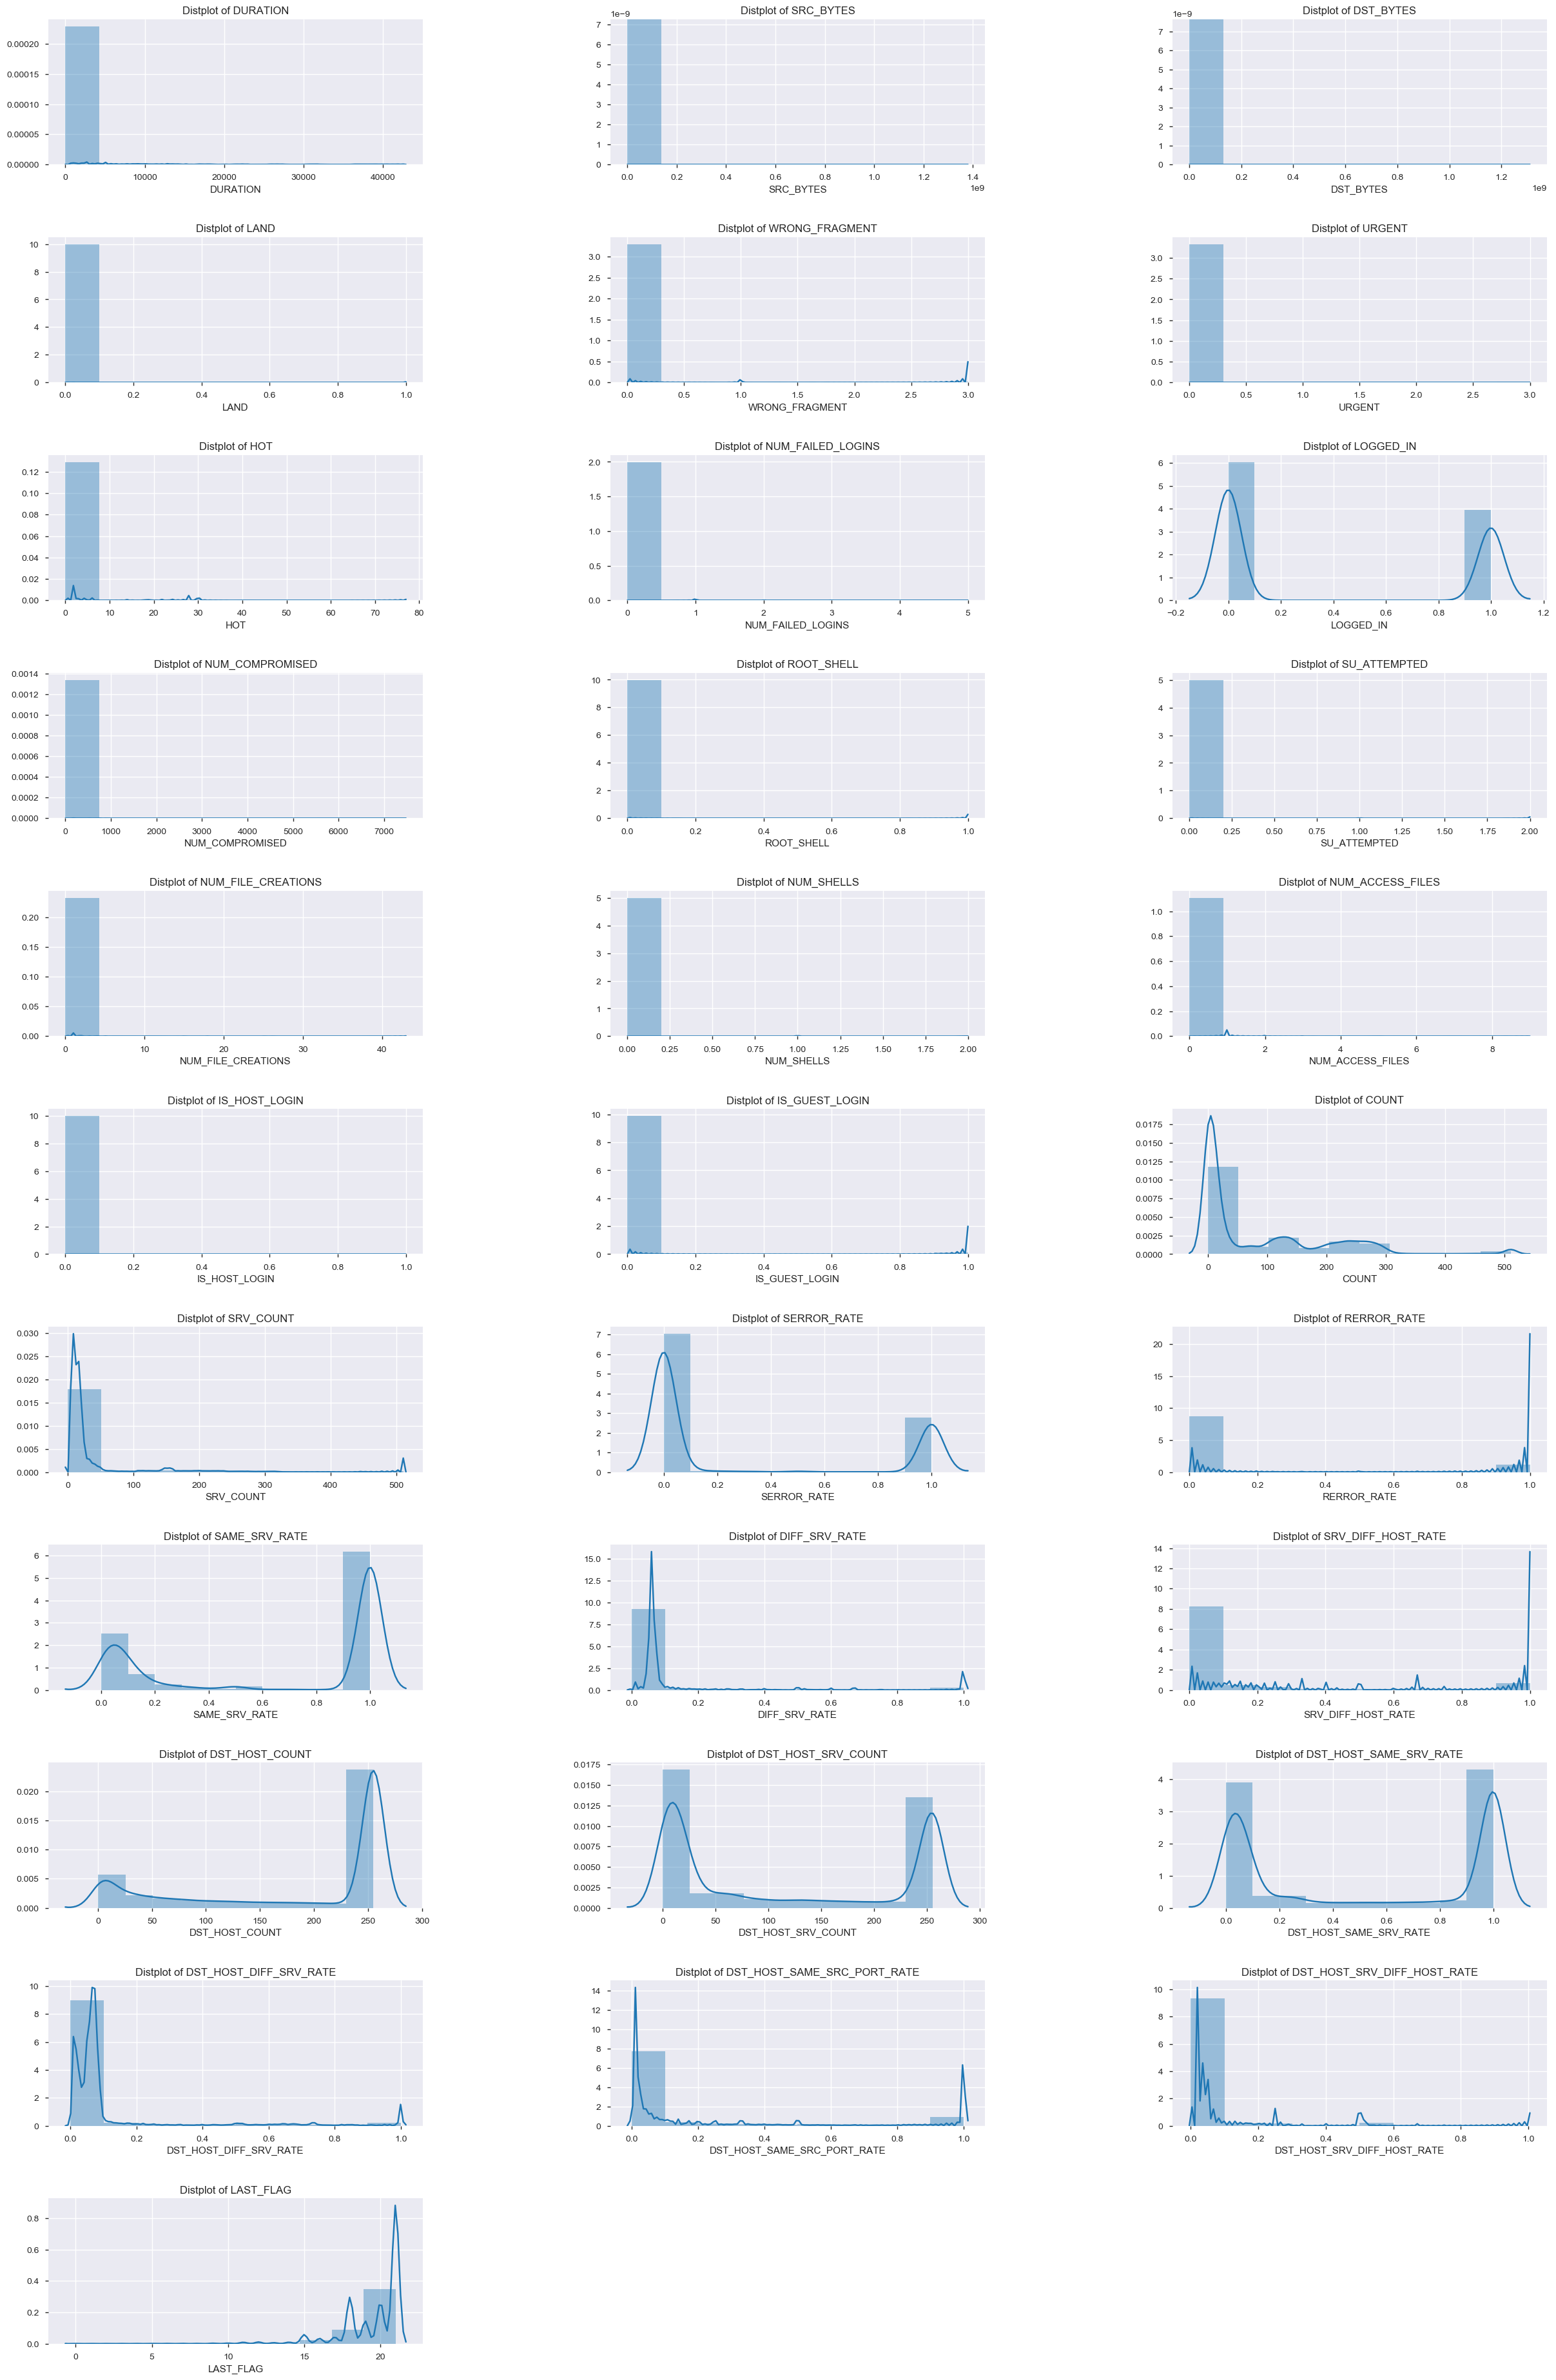

In [33]:
## Check outliers effect exist in the credit card data(without log)
plt.figure(1 , figsize = (30 , 60))
n = 0 
for x in network_data[numerical].columns:
    n += 1
    plt.subplot(14 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(network_data[x] , bins = 10)
    plt.title('Distplot of {}'.format(x))
plt.show()

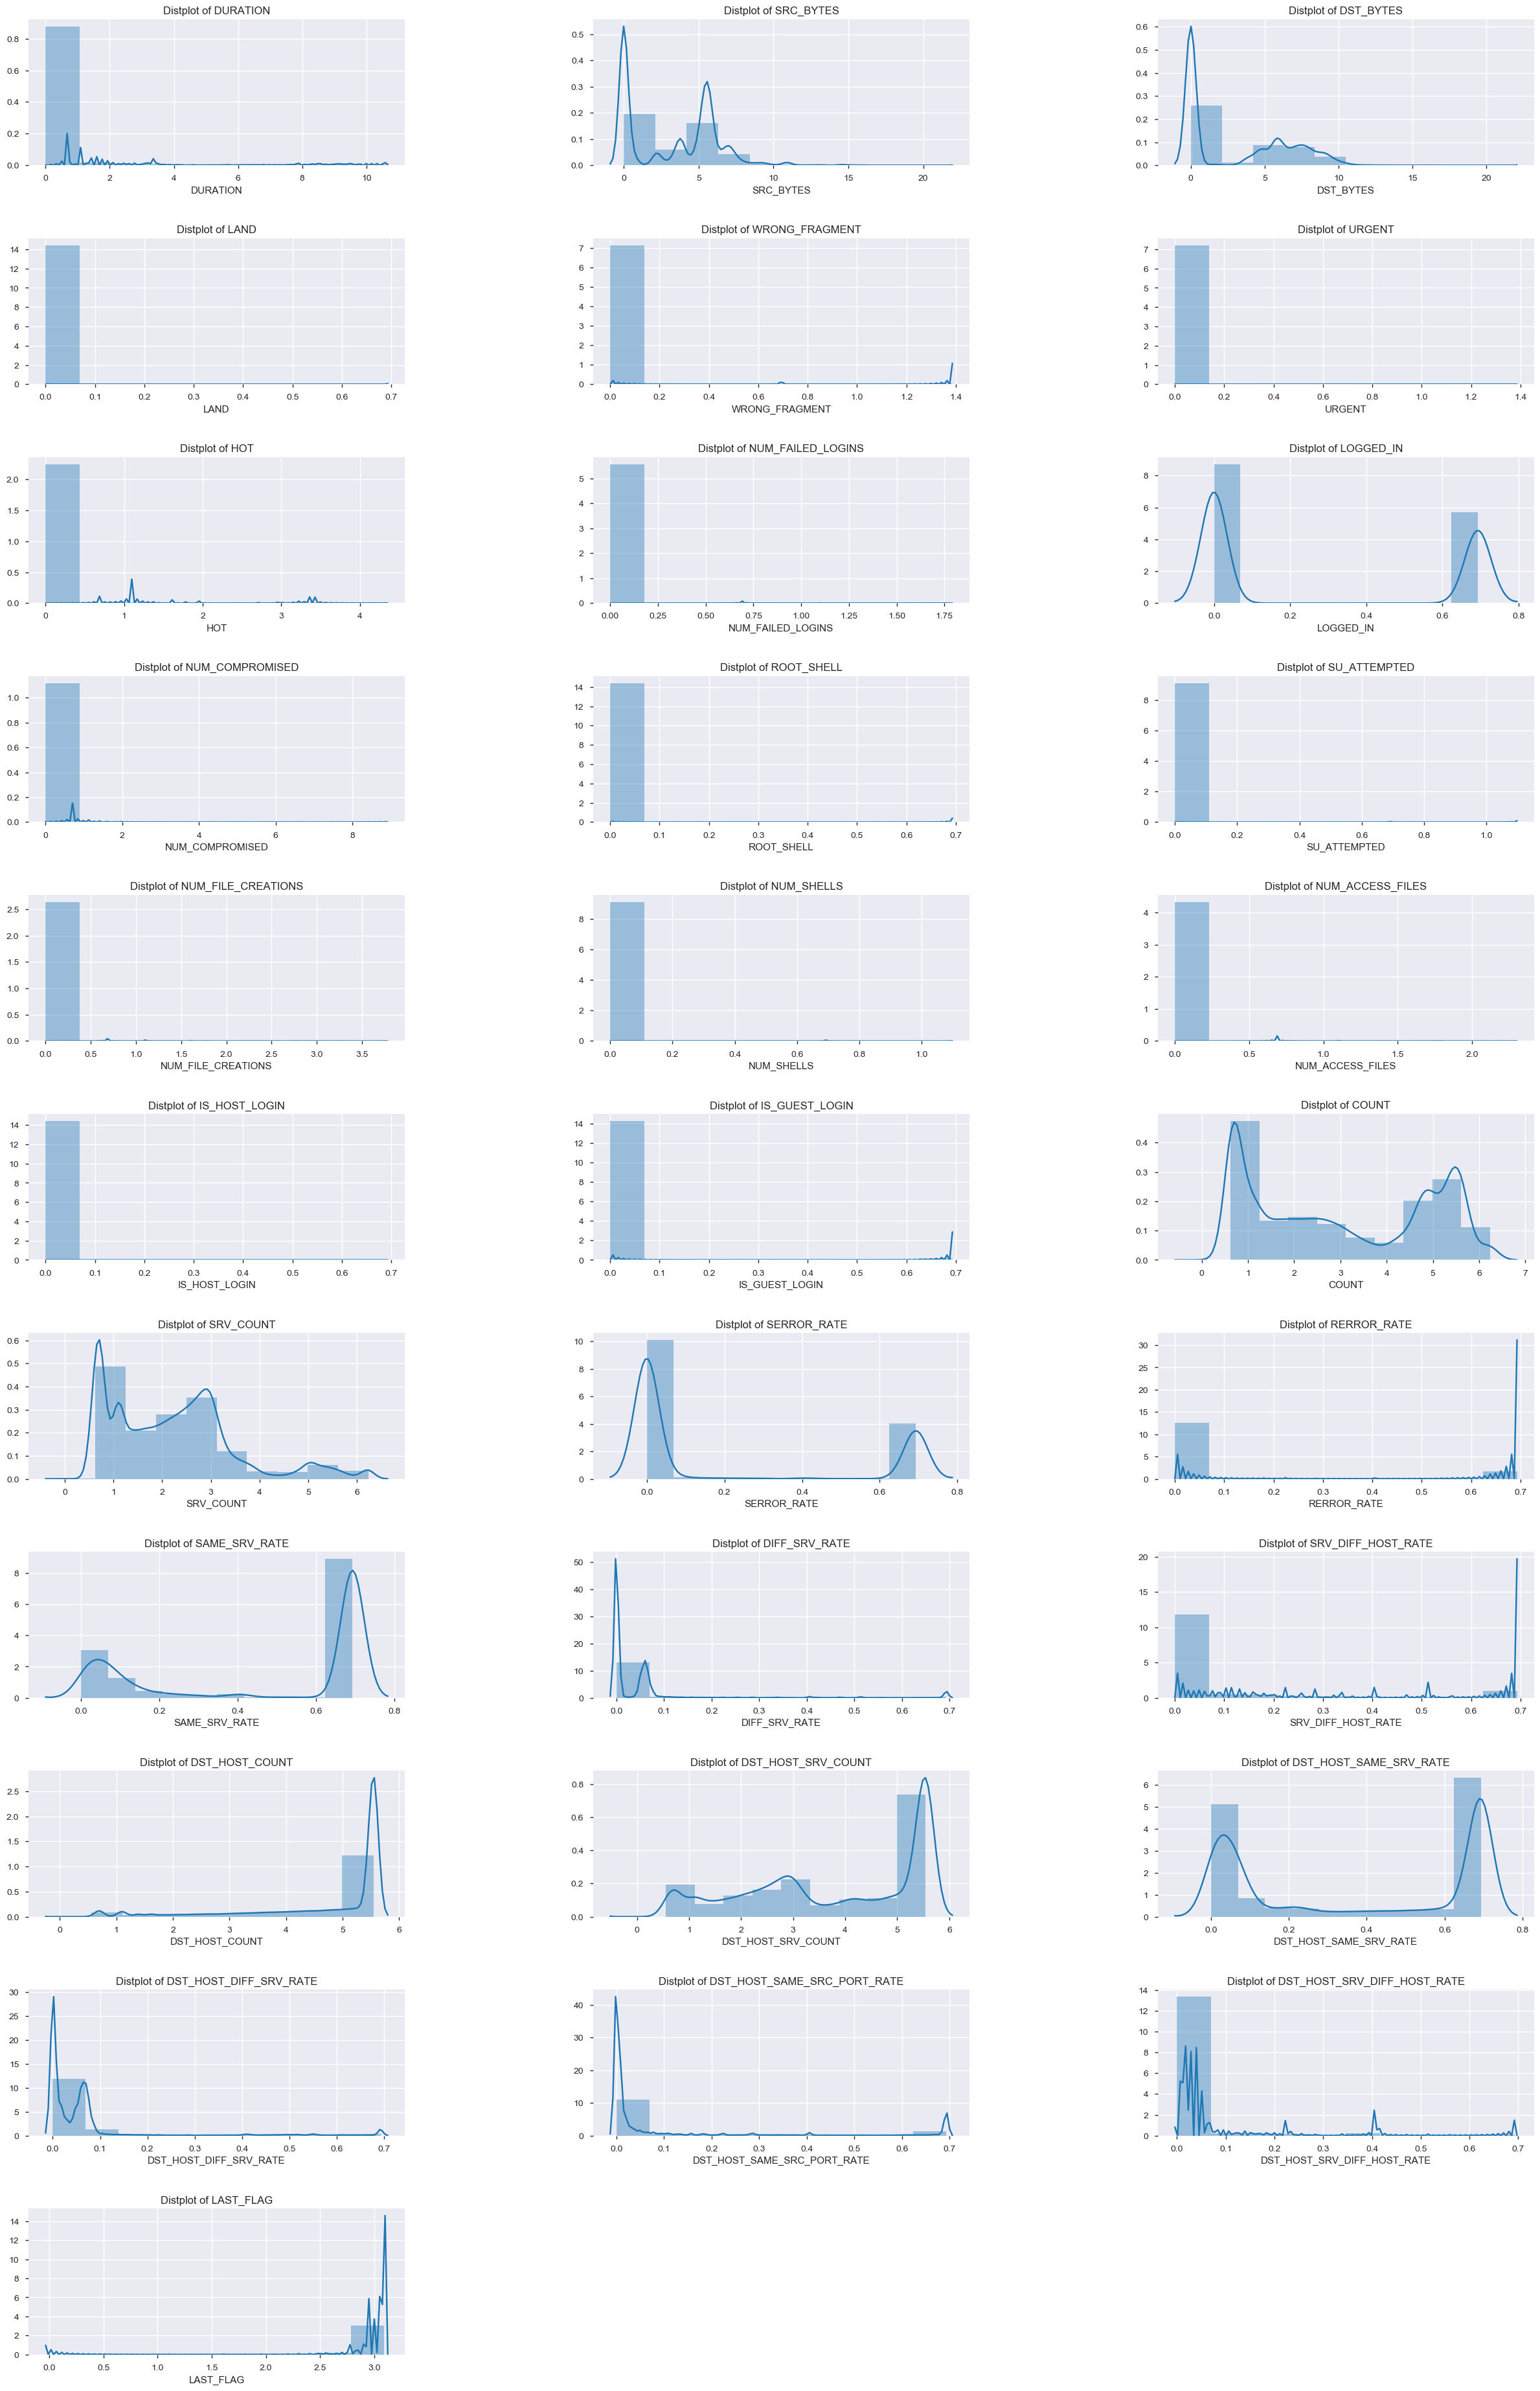

In [34]:
## Check outliers effect exist in the credit card data( applying log)
plt.figure(1 , figsize = (30 , 60))
n = 0 
for x in network_data[numerical].columns:
    n += 1
    plt.subplot(14 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(np.log(network_data[x]+1) , bins = 10)
    plt.title('Distplot of {}'.format(x))
plt.show()

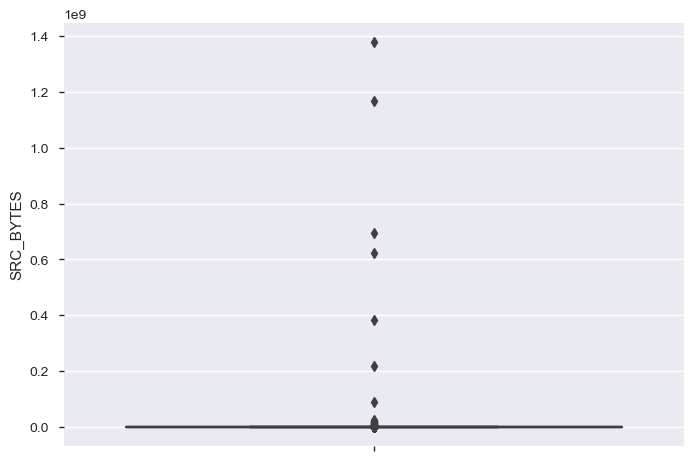

In [35]:
sns.boxplot(y="SRC_BYTES",data=network_data)

In [36]:
network_data_log=network_data[numerical].applymap(lambda x: np.log(x+1))

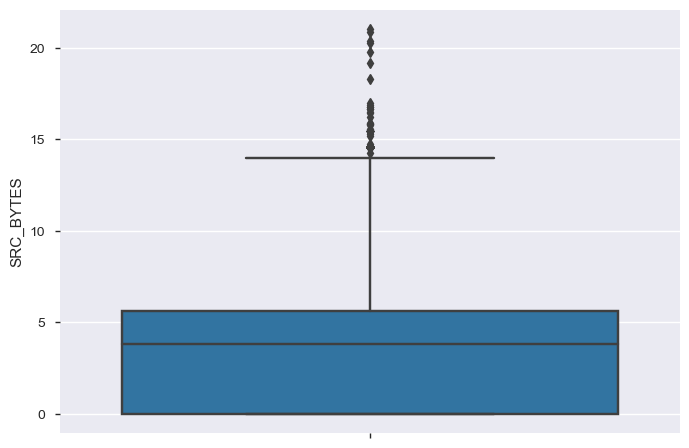

In [37]:
sns.boxplot(y="SRC_BYTES",data=network_data_log)

In [38]:
for col in numerical:
    network_data_log[col]=network_data_log[col].clip_upper(network_data_log[col].quantile(0.95))
    network_data_log[col]=network_data_log[col].clip_lower(network_data_log[col].quantile(0.05))

In [39]:
network_data_log.to_excel(writer,'Outlier_Treatment',index=True)

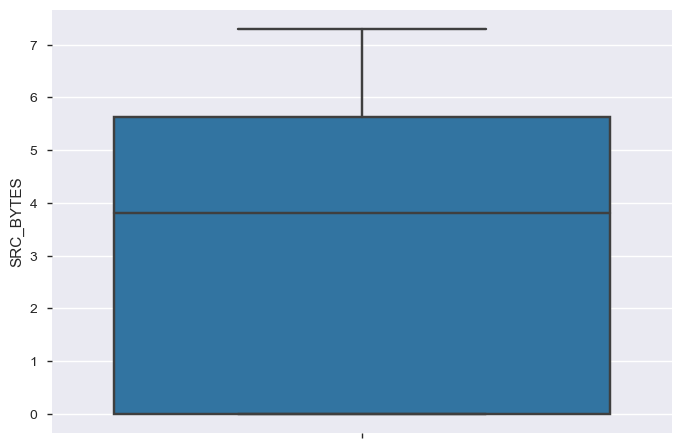

In [40]:

sns.boxplot(y="SRC_BYTES",data=network_data_log)

### Creation of Dummy variables

In [41]:
categorical

['PROTOCOL_TYPE', 'FLAG', 'ATTACK']

In [42]:
network_data_dummy=network_data

In [50]:
network_data=network_data_dummy

In [49]:
network_data_dummy.columns

Index(['DURATION', 'PROTOCOL_TYPE', 'FLAG', 'SRC_BYTES', 'DST_BYTES', 'LAND',
       'WRONG_FRAGMENT', 'URGENT', 'HOT', 'NUM_FAILED_LOGINS', 'LOGGED_IN',
       'NUM_COMPROMISED', 'ROOT_SHELL', 'SU_ATTEMPTED', 'NUM_FILE_CREATIONS',
       'NUM_SHELLS', 'NUM_ACCESS_FILES', 'IS_HOST_LOGIN', 'IS_GUEST_LOGIN',
       'COUNT', 'SRV_COUNT', 'SERROR_RATE', 'RERROR_RATE', 'SAME_SRV_RATE',
       'DIFF_SRV_RATE', 'SRV_DIFF_HOST_RATE', 'DST_HOST_COUNT',
       'DST_HOST_SRV_COUNT', 'DST_HOST_SAME_SRV_RATE',
       'DST_HOST_DIFF_SRV_RATE', 'DST_HOST_SAME_SRC_PORT_RATE',
       'DST_HOST_SRV_DIFF_HOST_RATE', 'ATTACK', 'LAST_FLAG'],
      dtype='object')

In [51]:
network_data.shape

(125973, 34)

In [52]:
network_data.columns

Index(['DURATION', 'PROTOCOL_TYPE', 'FLAG', 'SRC_BYTES', 'DST_BYTES', 'LAND',
       'WRONG_FRAGMENT', 'URGENT', 'HOT', 'NUM_FAILED_LOGINS', 'LOGGED_IN',
       'NUM_COMPROMISED', 'ROOT_SHELL', 'SU_ATTEMPTED', 'NUM_FILE_CREATIONS',
       'NUM_SHELLS', 'NUM_ACCESS_FILES', 'IS_HOST_LOGIN', 'IS_GUEST_LOGIN',
       'COUNT', 'SRV_COUNT', 'SERROR_RATE', 'RERROR_RATE', 'SAME_SRV_RATE',
       'DIFF_SRV_RATE', 'SRV_DIFF_HOST_RATE', 'DST_HOST_COUNT',
       'DST_HOST_SRV_COUNT', 'DST_HOST_SAME_SRV_RATE',
       'DST_HOST_DIFF_SRV_RATE', 'DST_HOST_SAME_SRC_PORT_RATE',
       'DST_HOST_SRV_DIFF_HOST_RATE', 'ATTACK', 'LAST_FLAG'],
      dtype='object')

In [53]:
for col in ['PROTOCOL_TYPE','FLAG']:
    network_data = create_dummies(network_data , col )

In [54]:
## Shape of data
network_data.shape

(125973, 44)

In [55]:
## Categorical dummy variables
dummy_var

['PROTOCOL_TYPE_tcp',
 'PROTOCOL_TYPE_udp',
 'FLAG_REJ',
 'FLAG_RSTO',
 'FLAG_RSTOS0',
 'FLAG_RSTR',
 'FLAG_S0',
 'FLAG_S1',
 'FLAG_S2',
 'FLAG_S3',
 'FLAG_SF',
 'FLAG_SH',
 'PROTOCOL_TYPE_tcp',
 'PROTOCOL_TYPE_udp',
 'FLAG_REJ',
 'FLAG_RSTO',
 'FLAG_RSTOS0',
 'FLAG_RSTR',
 'FLAG_S0',
 'FLAG_S1',
 'FLAG_S2',
 'FLAG_S3',
 'FLAG_SF',
 'FLAG_SH']

In [56]:
network_data.head()

,DURATION,SRC_BYTES,DST_BYTES,LAND,WRONG_FRAGMENT,URGENT,HOT,NUM_FAILED_LOGINS,LOGGED_IN,NUM_COMPROMISED,ROOT_SHELL,SU_ATTEMPTED,NUM_FILE_CREATIONS,NUM_SHELLS,NUM_ACCESS_FILES,IS_HOST_LOGIN,IS_GUEST_LOGIN,COUNT,SRV_COUNT,SERROR_RATE,RERROR_RATE,SAME_SRV_RATE,DIFF_SRV_RATE,SRV_DIFF_HOST_RATE,DST_HOST_COUNT,DST_HOST_SRV_COUNT,DST_HOST_SAME_SRV_RATE,DST_HOST_DIFF_SRV_RATE,DST_HOST_SAME_SRC_PORT_RATE,DST_HOST_SRV_DIFF_HOST_RATE,ATTACK,LAST_FLAG,PROTOCOL_TYPE_tcp,PROTOCOL_TYPE_udp,FLAG_REJ,FLAG_RSTO,FLAG_RSTOS0,FLAG_RSTR,FLAG_S0,FLAG_S1,FLAG_S2,FLAG_S3,FLAG_SF,FLAG_SH
0,0,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.000,0.000,1.000,0.000,0.000,150,25,0.170,0.030,0.170,0.000,normal,20,1,0,0,0,0,0,0,0,0,0,1,0
1,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.000,0.000,0.080,0.150,0.000,255,1,0.000,0.600,0.880,0.000,normal,15,0,1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.000,0.000,0.050,0.070,0.000,255,26,0.100,0.050,0.000,0.000,neptune,19,1,0,0,0,0,0,1,0,0,0,0,0
3,0,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,5,5,0.200,0.000,1.000,0.000,0.000,30,255,1.000,0.000,0.030,0.040,normal,21,1,0,0,0,0,0,0,0,0,0,1,0
4,0,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,30,32,0.000,0.000,1.000,0.000,0.090,255,255,1.000,0.000,0.000,0.000,normal,21,1,0,0,0,0,0,0,0,0,0,1,0


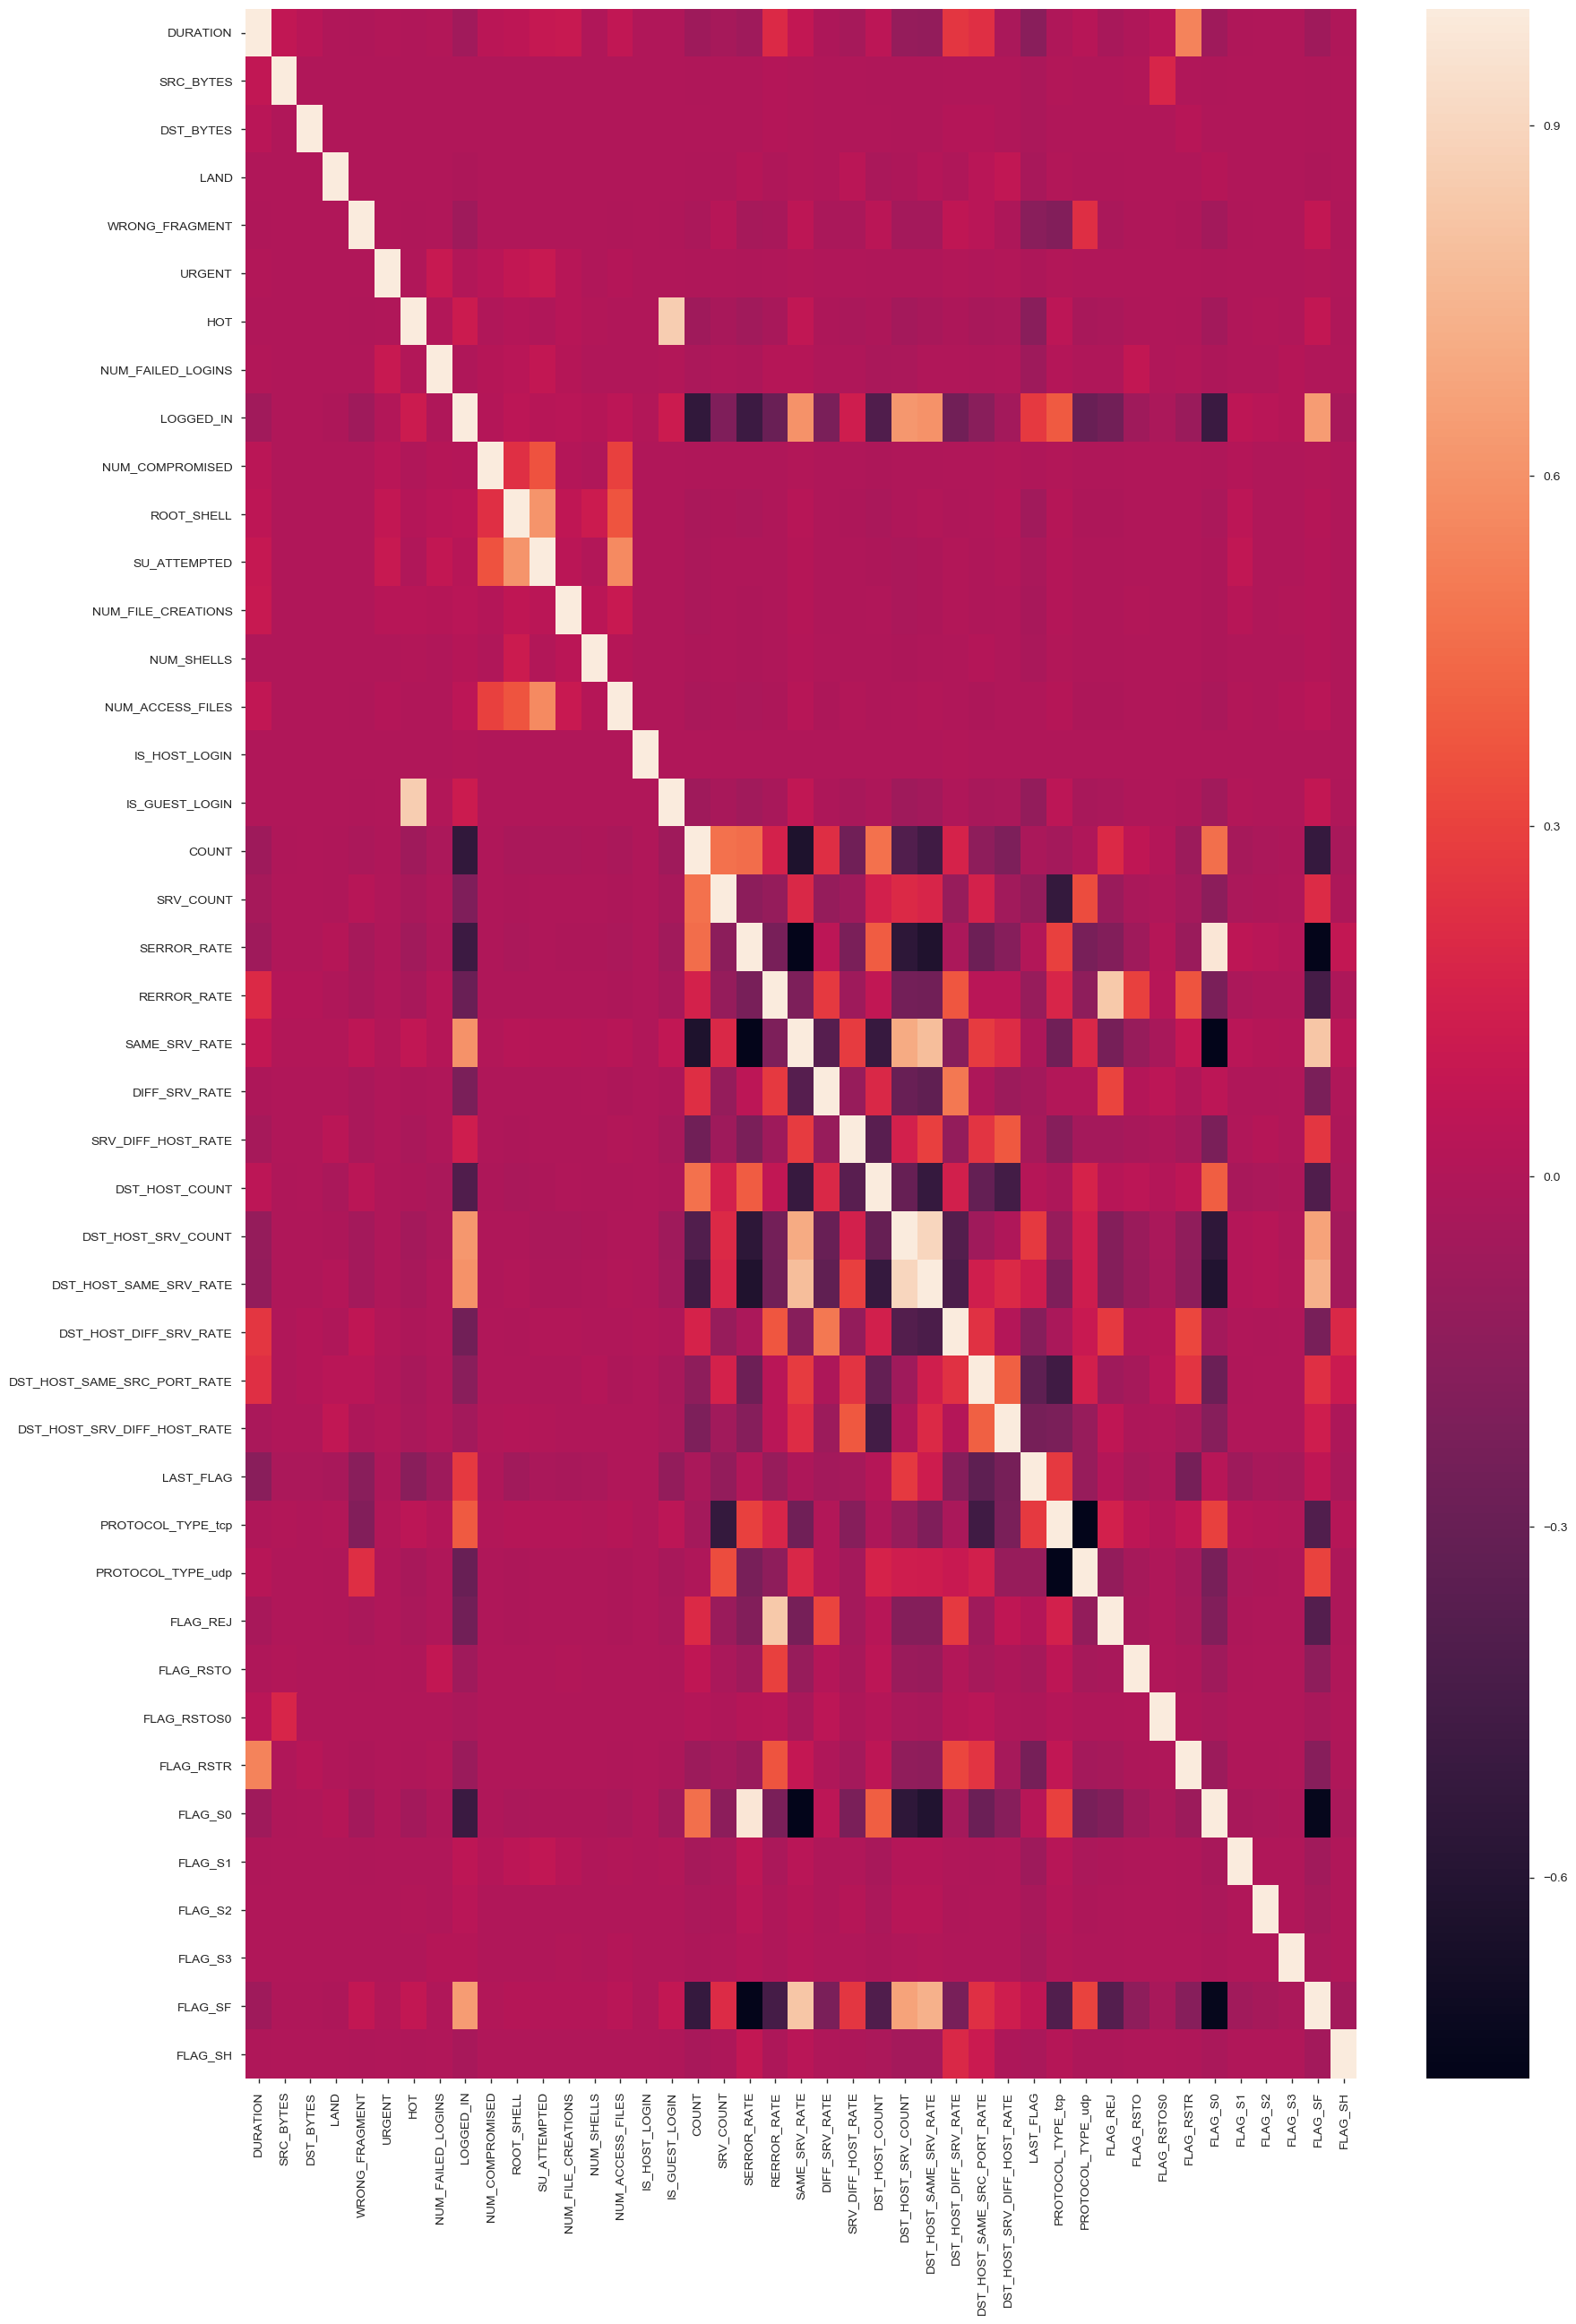

In [57]:
plt.figure(1 , figsize = (20 , 30))
sns.heatmap(network_data.corr())

In [59]:
network_data.corr().to_excel(writer,'Correlation',index=True)

In [60]:
network_data['ATTACK'].unique()

array(['normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep',
       'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back',
       'guess_passwd', 'ftp_write', 'multihop', 'rootkit',
       'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land',
       'loadmodule', 'spy', 'perl'], dtype=object)

In [53]:
network_data['ATTACK']=network_data_dummy['ATTACK']

In [61]:
## Creation of new dependent variable using ATTACK variable
network_data['ATTACK_BINARY']=np.where(network_data['ATTACK']=='normal',0,1)

In [62]:
network_data.head()

,DURATION,SRC_BYTES,DST_BYTES,LAND,WRONG_FRAGMENT,URGENT,HOT,NUM_FAILED_LOGINS,LOGGED_IN,NUM_COMPROMISED,ROOT_SHELL,SU_ATTEMPTED,NUM_FILE_CREATIONS,NUM_SHELLS,NUM_ACCESS_FILES,IS_HOST_LOGIN,IS_GUEST_LOGIN,COUNT,SRV_COUNT,SERROR_RATE,RERROR_RATE,SAME_SRV_RATE,DIFF_SRV_RATE,SRV_DIFF_HOST_RATE,DST_HOST_COUNT,DST_HOST_SRV_COUNT,DST_HOST_SAME_SRV_RATE,DST_HOST_DIFF_SRV_RATE,DST_HOST_SAME_SRC_PORT_RATE,DST_HOST_SRV_DIFF_HOST_RATE,ATTACK,LAST_FLAG,PROTOCOL_TYPE_tcp,PROTOCOL_TYPE_udp,FLAG_REJ,FLAG_RSTO,FLAG_RSTOS0,FLAG_RSTR,FLAG_S0,FLAG_S1,FLAG_S2,FLAG_S3,FLAG_SF,FLAG_SH,ATTACK_BINARY
0,0,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.000,0.000,1.000,0.000,0.000,150,25,0.170,0.030,0.170,0.000,normal,20,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.000,0.000,0.080,0.150,0.000,255,1,0.000,0.600,0.880,0.000,normal,15,0,1,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.000,0.000,0.050,0.070,0.000,255,26,0.100,0.050,0.000,0.000,neptune,19,1,0,0,0,0,0,1,0,0,0,0,0,1
3,0,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,5,5,0.200,0.000,1.000,0.000,0.000,30,255,1.000,0.000,0.030,0.040,normal,21,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,30,32,0.000,0.000,1.000,0.000,0.090,255,255,1.000,0.000,0.000,0.000,normal,21,1,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
## Drop the ATTACK variable due to high correlation with ATTACK_BINARY

In [63]:
for col in ['ATTACK']:
    remove_columns_from_list(col)
    remove_columns_from_main_set(col)
    

In [64]:
network_data.shape

(125973, 44)

### Variable Reduction

In [65]:
somersd_df = pd.DataFrame()
for num_variable in network_data.columns.difference(['ATTACK_BINARY']):
    logreg = sm.logit(formula = str('ATTACK_BINARY ~ ')+str(num_variable), data=network_data)
    result = logreg.fit()
    #summ = result.summary2()
    y_score = pd.DataFrame(result.predict())
    y_score.columns = ['Score']
    somers_d = 2*metrics.roc_auc_score(network_data['ATTACK_BINARY'],y_score) - 1
    temp = pd.DataFrame([num_variable,somers_d]).T
    temp.columns = ['Variable Name', 'SomersD']
    somersd_df = pd.concat([somersd_df, temp], axis=0)

somersd_df

Optimization terminated successfully.
         Current function value: 0.474707
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.666611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690741
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.615406
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656414
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686483
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.421391
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380619
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688793
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689516
  

,Variable Name,SomersD
0,COUNT,0.642
0,DIFF_SRV_RATE,0.689
0,DST_BYTES,-0.799
0,DST_HOST_COUNT,0.414
0,DST_HOST_DIFF_SRV_RATE,0.653
0,DST_HOST_SAME_SRC_PORT_RATE,-0.259
0,DST_HOST_SAME_SRV_RATE,0.731
0,DST_HOST_SRV_COUNT,0.785
0,DST_HOST_SRV_DIFF_HOST_RATE,-0.364
0,DURATION,-0.082


In [59]:
somersd_df.sort_values(by='SomersD', ascending=False)

,Variable Name,SomersD
0,DST_HOST_SRV_COUNT,0.785
0,SAME_SRV_RATE,0.748
0,FLAG_SF,0.744
0,DST_HOST_SAME_SRV_RATE,0.731
0,DIFF_SRV_RATE,0.689
0,LOGGED_IN,0.677
0,DST_HOST_DIFF_SRV_RATE,0.653
0,COUNT,0.642
0,SERROR_RATE,0.612
0,FLAG_S0,0.583


In [ ]:
## Selected Columns list using somersd

In [66]:
sel_list=['DST_HOST_SRV_COUNT','SAME_SRV_RATE','FLAG_SF','DST_HOST_SAME_SRV_RATE','DIFF_SRV_RATE','LOGGED_IN','DST_HOST_DIFF_SRV_RATE','COUNT','SERROR_RATE','FLAG_S0','DST_HOST_COUNT','SRV_DIFF_HOST_RATE','RERROR_RATE','PROTOCOL_TYPE_udp']

In [67]:
network_data[sel_list]

,DST_HOST_SRV_COUNT,SAME_SRV_RATE,FLAG_SF,DST_HOST_SAME_SRV_RATE,DIFF_SRV_RATE,LOGGED_IN,DST_HOST_DIFF_SRV_RATE,COUNT,SERROR_RATE,FLAG_S0,DST_HOST_COUNT,SRV_DIFF_HOST_RATE,RERROR_RATE,PROTOCOL_TYPE_udp
0,25,1.000,1,0.170,0.000,0,0.030,2,0.000,0,150,0.000,0.000,0
1,1,0.080,1,0.000,0.150,0,0.600,13,0.000,0,255,0.000,0.000,1
2,26,0.050,0,0.100,0.070,0,0.050,123,1.000,1,255,0.000,0.000,0
3,255,1.000,1,1.000,0.000,1,0.000,5,0.200,0,30,0.000,0.000,0
4,255,1.000,1,1.000,0.000,1,0.000,30,0.000,0,255,0.090,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,25,0.140,0,0.100,0.060,0,0.060,184,1.000,1,255,0.000,0.000,0
125969,244,1.000,1,0.960,0.000,0,0.010,2,0.000,0,255,0.000,0.000,1
125970,30,1.000,1,0.120,0.000,1,0.060,1,0.000,0,255,0.000,0.000,0
125971,8,0.060,0,0.030,0.050,0,0.050,144,1.000,1,255,0.000,0.000,0


In [68]:
## Variance Inflation Factor assessment
X = pd.concat([network_data[sel_list],network_data['ATTACK_BINARY']], axis=1)

features = "+".join(network_data[sel_list].columns.difference(['ATTACK_BINARY']))
X.head()

,DST_HOST_SRV_COUNT,SAME_SRV_RATE,FLAG_SF,DST_HOST_SAME_SRV_RATE,DIFF_SRV_RATE,LOGGED_IN,DST_HOST_DIFF_SRV_RATE,COUNT,SERROR_RATE,FLAG_S0,DST_HOST_COUNT,SRV_DIFF_HOST_RATE,RERROR_RATE,PROTOCOL_TYPE_udp,ATTACK_BINARY
0,25,1.000,1,0.170,0.000,0,0.030,2,0.000,0,150,0.000,0.000,0,0
1,1,0.080,1,0.000,0.150,0,0.600,13,0.000,0,255,0.000,0.000,1,0
2,26,0.050,0,0.100,0.070,0,0.050,123,1.000,1,255,0.000,0.000,0,1
3,255,1.000,1,1.000,0.000,1,0.000,5,0.200,0,30,0.000,0.000,0,0
4,255,1.000,1,1.000,0.000,1,0.000,30,0.000,0,255,0.090,0.000,0,0


In [69]:
network_data.shape

(125973, 44)

In [70]:
features

'COUNT+DIFF_SRV_RATE+DST_HOST_COUNT+DST_HOST_DIFF_SRV_RATE+DST_HOST_SAME_SRV_RATE+DST_HOST_SRV_COUNT+FLAG_S0+FLAG_SF+LOGGED_IN+PROTOCOL_TYPE_udp+RERROR_RATE+SAME_SRV_RATE+SERROR_RATE+SRV_DIFF_HOST_RATE'

In [71]:
a,b = dmatrices(formula_like='ATTACK_BINARY ~ '+ 'DST_HOST_SRV_COUNT+SAME_SRV_RATE+FLAG_SF+DST_HOST_SAME_SRV_RATE+DIFF_SRV_RATE+LOGGED_IN+DST_HOST_DIFF_SRV_RATE+COUNT+SERROR_RATE+FLAG_S0+DST_HOST_COUNT+SRV_DIFF_HOST_RATE+RERROR_RATE+PROTOCOL_TYPE_udp', data = X, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns

print(vif)

    VIF Factor                features
0      299.344               Intercept
1        7.324      DST_HOST_SRV_COUNT
2        7.876           SAME_SRV_RATE
3       58.220                 FLAG_SF
4       10.269  DST_HOST_SAME_SRV_RATE
5        1.837           DIFF_SRV_RATE
6        4.381               LOGGED_IN
7        2.103  DST_HOST_DIFF_SRV_RATE
8        2.038                   COUNT
9       55.991             SERROR_RATE
10      29.346                 FLAG_S0
11       2.069          DST_HOST_COUNT
12       1.266      SRV_DIFF_HOST_RATE
13      27.590             RERROR_RATE
14       2.505       PROTOCOL_TYPE_udp


In [72]:
vif.sort_values(by='VIF Factor', ascending=False)

,VIF Factor,features
0,299.344,Intercept
3,58.220,FLAG_SF
9,55.991,SERROR_RATE
10,29.346,FLAG_S0
13,27.590,RERROR_RATE
4,10.269,DST_HOST_SAME_SRV_RATE
2,7.876,SAME_SRV_RATE
1,7.324,DST_HOST_SRV_COUNT
6,4.381,LOGGED_IN
14,2.505,PROTOCOL_TYPE_udp


In [73]:
c,d = dmatrices(formula_like='ATTACK_BINARY ~ '+ 'DST_HOST_SRV_COUNT+DIFF_SRV_RATE+LOGGED_IN+DST_HOST_DIFF_SRV_RATE+COUNT+SERROR_RATE+DST_HOST_COUNT+SRV_DIFF_HOST_RATE+RERROR_RATE+PROTOCOL_TYPE_udp', data = X, return_type='dataframe')

vif1 = pd.DataFrame()
vif1["VIF Factor"] = [variance_inflation_factor(d.values, i) for i in range(d.shape[1])]
vif1["features"] = d.columns

vif1.sort_values(by='VIF Factor', ascending=False)

,VIF Factor,features
0,18.443,Intercept
3,4.090,LOGGED_IN
6,3.683,SERROR_RATE
1,2.551,DST_HOST_SRV_COUNT
10,2.418,PROTOCOL_TYPE_udp
9,2.319,RERROR_RATE
5,1.750,COUNT
4,1.679,DST_HOST_DIFF_SRV_RATE
7,1.595,DST_HOST_COUNT
2,1.395,DIFF_SRV_RATE


In [74]:
X_VIF=['LOGGED_IN','SERROR_RATE','DST_HOST_SRV_COUNT','PROTOCOL_TYPE_udp','RERROR_RATE','DST_HOST_DIFF_SRV_RATE','DST_HOST_COUNT','DIFF_SRV_RATE','SRV_DIFF_HOST_RATE']

In [75]:
X_feature=X[X_VIF]
Y=X['ATTACK_BINARY']

In [76]:
network_final_data=pd.concat([X_feature,Y],axis=1)

In [77]:
network_final_data.shape

(125973, 10)

In [78]:
train, test = train_test_split(network_final_data, test_size = 0.3, random_state =1023)

In [79]:
X_VIF1='+'.join(X_VIF)

In [80]:
X_VIF1

'LOGGED_IN+SERROR_RATE+DST_HOST_SRV_COUNT+PROTOCOL_TYPE_udp+RERROR_RATE+DST_HOST_DIFF_SRV_RATE+DST_HOST_COUNT+DIFF_SRV_RATE+SRV_DIFF_HOST_RATE'

### Applying Logistic regression

In [81]:
logreg = sm.logit(formula='ATTACK_BINARY ~ LOGGED_IN+SERROR_RATE+DST_HOST_SRV_COUNT+PROTOCOL_TYPE_udp+RERROR_RATE+DST_HOST_DIFF_SRV_RATE+DST_HOST_COUNT+DIFF_SRV_RATE+SRV_DIFF_HOST_RATE', data=train)
result = logreg.fit()

Optimization terminated successfully.
         Current function value: 0.208118
         Iterations 8


In [82]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                Logit              Pseudo R-squared:   0.699     
Dependent Variable:   ATTACK_BINARY      AIC:                36724.0830
Date:                 2020-08-16 11:06   BIC:                36817.9545
No. Observations:     88181              Log-Likelihood:     -18352.   
Df Model:             9                  LL-Null:            -60899.   
Df Residuals:         88171              LLR p-value:        0.0000    
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       8.0000                                           
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept               0.5748   0.0403  14.2757 0.0000  0.4959  0.6537
LOGGED_IN              -3.3797   0.0385 -87.8409 0.0000 -3.4551 -3.3043
SERROR_RATE             2.8516   0.0644  44.3090 0.0000  2.7254  2.9777
DST_HOST_SRV_COUNT     -0.0098   0.0002 -60.2278 0.0000 -0.0102 -0.0095
PROTOCOL_TYPE_udp      -2.4885   0.0437 -56.9182 0.0000 -2.5742 -2.4028
RERROR_RATE             0.3712   0.0417   8.9124 0.0000  0.2896  0.4529
DST_HOST_DIFF_SRV_RATE  0.7323   0.0701  10.4478 0.0000  0.5949  0.8696
DST_HOST_COUNT          0.0059   0.0002  36.9007 0.0000  0.0056  0.0062
DIFF_SRV_RATE          -1.0930   0.0670 -16.3095 0.0000 -1.2243 -0.9616
SRV_DIFF_HOST_RATE      1.2451   0.0427  29.1646 0.0000  1.1614  1.3288
=======================================================================

"""

In [84]:
train_gini = 2*metrics.roc_auc_score(train['ATTACK_BINARY'], result.predict(train)) - 1
print("The Gini Index for the model built on the Train Data is : ", train_gini)

test_gini = 2*metrics.roc_auc_score(test['ATTACK_BINARY'], result.predict(test)) - 1
print("The Gini Index for the model built on the Test Data is : ", test_gini)

The Gini Index for the model built on the Train Data is :  0.9457718530627948
The Gini Index for the model built on the Test Data is :  0.9470575838401711


In [85]:
train_auc = metrics.roc_auc_score(train['ATTACK_BINARY'], result.predict(train))
test_auc = metrics.roc_auc_score(test['ATTACK_BINARY'], result.predict(test))

print("The AUC for the model built on the Train Data is : ", train_auc)
print("The AUC for the model built on the Test Data is : ", test_auc)
                                 

The AUC for the model built on the Train Data is :  0.9728859265313974
The AUC for the model built on the Test Data is :  0.9735287919200856


In [86]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
train_predicted_prob = pd.DataFrame(result.predict(train))
train_predicted_prob.columns = ['prob']
train_actual = train['ATTACK_BINARY']
# making a DataFrame with actual and prob columns
train_predict = pd.concat([train_actual, train_predicted_prob], axis=1)
train_predict.columns = ['actual','prob']
train_predict.head()

,actual,prob
31357,1,0.991
62513,0,0.013
113103,0,0.005
93166,0,0.023
97219,0,0.165


In [87]:
test.head()

,LOGGED_IN,SERROR_RATE,DST_HOST_SRV_COUNT,PROTOCOL_TYPE_udp,RERROR_RATE,DST_HOST_DIFF_SRV_RATE,DST_HOST_COUNT,DIFF_SRV_RATE,SRV_DIFF_HOST_RATE,ATTACK_BINARY
111226,0,0.000,8,0,1.000,0.080,255,0.070,0.000,1
49717,0,1.000,23,0,0.000,0.050,255,0.050,0.000,1
99390,1,0.000,255,0,0.000,0.000,35,0.000,0.000,0
86456,1,0.000,238,0,0.000,0.070,59,0.000,1.000,0
83641,0,0.000,153,0,0.000,0.000,1,0.000,1.000,1


In [88]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
test_predicted_prob = pd.DataFrame(result.predict(test))
test_predicted_prob.columns = ['prob']
test_actual = test['ATTACK_BINARY']
# making a DataFrame with actual and prob columns
test_predict = pd.concat([test_actual, test_predicted_prob], axis=1)
test_predict.columns = ['actual','prob']
test_predict.head()

,actual,prob
111226,1,0.913
49717,1,0.991
99390,0,0.006
86456,0,0.029
83641,1,0.579


In [89]:
network_data['ATTACK_BINARY'].value_counts()

0    67343
1    58630
Name: ATTACK_BINARY, dtype: int64

In [90]:
train_predict['predicted'] = train_predict['prob'].apply(lambda x: 0.0 if x < 0.4 else 1.0)

In [103]:
test_predict['predicted'] = test_predict['prob'].apply(lambda x: 0.0 if x < 0.4 else 1.0)

In [91]:
train_predict.head()

,actual,prob,predicted
31357,1,0.991,1.000
62513,0,0.013,0.000
113103,0,0.005,0.000
93166,0,0.023,0.000
97219,0,0.165,0.000


In [92]:
train_predict['tp'] = train_predict.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
train_predict['fp'] = train_predict.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
train_predict['tn'] = train_predict.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
train_predict['fn'] = train_predict.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)

In [93]:
train_predict['tp'].sum()

37296.0

In [94]:
train_predict['fp'].sum()

5060.0

In [95]:
train_predict['tn'].sum()

42170.0

In [96]:
train_predict['fn'].sum()

3655.0

In [97]:
train_predict.head()

,actual,prob,predicted,tp,fp,tn,fn
31357,1,0.991,1.000,1.000,0.000,0.000,0.000
62513,0,0.013,0.000,0.000,0.000,1.000,0.000
113103,0,0.005,0.000,0.000,0.000,1.000,0.000
93166,0,0.023,0.000,0.000,0.000,1.000,0.000
97219,0,0.165,0.000,0.000,0.000,1.000,0.000


In [98]:
train_predict.to_excel(writer,'train_prediction',index=True)

In [99]:
accuracy = (train_predict.tp.sum()+train_predict.tn.sum())/(train_predict.tp.sum()+train_predict.tn.sum()+train_predict.fp.sum()+train_predict.fn.sum())

In [100]:
accuracy

0.9011691861058505

In [101]:
Sensitivity = (train_predict.tp.sum())/(train_predict.tp.sum()+train_predict.fn.sum())
Sensitivity

0.910746990305487

In [104]:
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_predict.actual, train_predict.predicted))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_predict.actual, test_predict.predicted))

The overall accuracy score for the Train Data is :  0.9011691861058505
The overall accuracy score for the Test Data  is :  0.9028630397967824


In [105]:
print(metrics.classification_report(train_predict.actual, train_predict.predicted))

              precision    recall  f1-score   support

           0       0.92      0.89      0.91     47230
           1       0.88      0.91      0.90     40951

    accuracy                           0.90     88181
   macro avg       0.90      0.90      0.90     88181
weighted avg       0.90      0.90      0.90     88181



### ROC AUC curve

In [106]:
def show_graph(defaulter,probab,fig_size = (6,6),graph_title =''):
    import matplotlib.pyplot as plt
    y_true = defaulter
    y_probas = probab
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_probas, pos_label=1)

    # Print ROC curve
    plt.figure(figsize=fig_size)
    plt.plot(fpr,tpr,'g')

    plt.title('AUC Curve \n'+graph_title )
    plt.plot([0,1],[0,1],'y--')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.show()

    # Print AUC
    auc = np.trapz(tpr,fpr)
    print('AUC:', round(auc*100,2))

    return plt

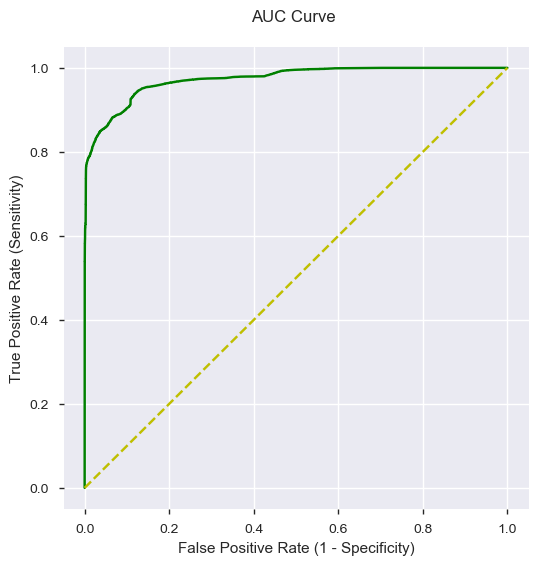

AUC: 97.29


<module 'matplotlib.pyplot' from 'C:\\Users\\PIYUSH\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [107]:
### ROC AUC curve on train data

show_graph(train['ATTACK_BINARY'],train_predict['prob'])

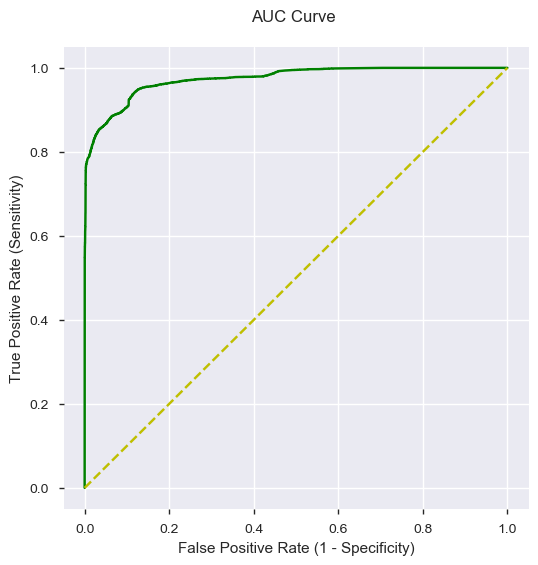

AUC: 97.35


<module 'matplotlib.pyplot' from 'C:\\Users\\PIYUSH\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [108]:
### ROC AUC curve on test data

show_graph(test['ATTACK_BINARY'],test_predict['prob'])

### Calculation of cutoff to decide 1 and 0 based on probability

In [109]:
## Intuition behind ROC curve - confusion matrix for each different cut-off shows trade off in sensitivity and specificity
roc_like_df = pd.DataFrame()
train_temp = train_predict.copy()

for cut_off in np.linspace(0,1,50):
    train_temp['cut_off'] = cut_off
    train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x < cut_off else 1.0)
    train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
    train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
    sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
    specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
    accuracy = (train_temp['tp'].sum()  + train_temp['tn'].sum() ) / (train_temp['tp'].sum() + train_temp['fn'].sum() + train_temp['tn'].sum() + train_temp['fp'].sum())
    roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity, accuracy]).T
    roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity', 'accuracy']
    roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)


In [112]:
roc_like_df.to_excel(writer,'cut_off_sensitivity',index=True)
roc_like_df

,cutoff,sensitivity,specificity,accuracy
0,0.000,1.000,0.000,0.464
0,0.020,1.000,0.316,0.634
0,0.041,0.989,0.546,0.752
0,0.061,0.975,0.679,0.816
0,0.082,0.972,0.740,0.848
0,0.102,0.968,0.774,0.864
0,0.122,0.965,0.796,0.875
0,0.143,0.961,0.817,0.883
0,0.163,0.958,0.829,0.889
0,0.184,0.956,0.843,0.895


In [113]:
## Finding ideal cut-off for checking if this remains same in OOS validation
roc_like_df['total'] = roc_like_df['sensitivity'] + roc_like_df['specificity']

In [114]:
roc_like_df.head()

,cutoff,sensitivity,specificity,accuracy,total
0,0.000,1.000,0.000,0.464,1.000
0,0.020,1.000,0.316,0.634,1.316
0,0.041,0.989,0.546,0.752,1.535
0,0.061,0.975,0.679,0.816,1.654
0,0.082,0.972,0.740,0.848,1.712


In [115]:
#Cut-off based on highest sum(sensitivity+specicity)   - common way of identifying cut-off
roc_like_df[roc_like_df['total']==roc_like_df['total'].max()]

,cutoff,sensitivity,specificity,accuracy,total
0,0.327,0.938,0.881,0.908,1.820


In [116]:
roc_like_df[roc_like_df['total']==roc_like_df['total'].max()].to_excel(writer,'Selected_cutoff',index=True)

In [117]:
test_predict['predicted'] = test_predict['prob'].apply(lambda x: 1 if x > 0.32 else 0)
train_predict['predicted'] = train_predict['prob'].apply(lambda x: 1 if x > 0.32 else 0)

In [118]:
pd.crosstab(train_predict['actual'], train_predict['predicted'])

predicted,0,1
actual,,
0,41545,5685
1,2490,38461


In [119]:
pd.crosstab(test_predict['actual'], test_predict['predicted'])

predicted,0,1
actual,,
0,17775,2338
1,1083,16596


### Accuracy and classification report of model

In [120]:
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_predict.actual, train_predict.predicted))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_predict.actual, test_predict.predicted))

The overall accuracy score for the Train Data is :  0.907292954264524
The overall accuracy score for the Test Data  is :  0.9094781964436918


In [121]:
print(metrics.classification_report(train_predict.actual, train_predict.predicted))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91     47230
           1       0.87      0.94      0.90     40951

    accuracy                           0.91     88181
   macro avg       0.91      0.91      0.91     88181
weighted avg       0.91      0.91      0.91     88181



## Prediction of attack or normal on new test data

In [122]:
network_test=pd.read_csv('NSL_Dataset\Test.txt',sep=',',header=None)

In [123]:
network_test.columns=total_features

In [124]:
network_test.head()

,DURATION,PROTOCOL_TYPE,SERVICE,FLAG,SRC_BYTES,DST_BYTES,LAND,WRONG_FRAGMENT,URGENT,HOT,NUM_FAILED_LOGINS,LOGGED_IN,NUM_COMPROMISED,ROOT_SHELL,SU_ATTEMPTED,NUM_ROOT,NUM_FILE_CREATIONS,NUM_SHELLS,NUM_ACCESS_FILES,NUM_OUTBOUND_CMDS,IS_HOST_LOGIN,IS_GUEST_LOGIN,COUNT,SRV_COUNT,SERROR_RATE,SRV_SERROR_RATE,RERROR_RATE,SRV_RERROR_RATE,SAME_SRV_RATE,DIFF_SRV_RATE,SRV_DIFF_HOST_RATE,DST_HOST_COUNT,DST_HOST_SRV_COUNT,DST_HOST_SAME_SRV_RATE,DST_HOST_DIFF_SRV_RATE,DST_HOST_SAME_SRC_PORT_RATE,DST_HOST_SRV_DIFF_HOST_RATE,DST_HOST_SERROR_RATE,DST_HOST_SRV_SERROR_RATE,DST_HOST_RERROR_RATE,DST_HOST_SRV_RERROR_RATE,ATTACK,LAST_FLAG
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.000,0.000,1.000,1.000,0.040,0.060,0.000,255,10,0.040,0.060,0.000,0.000,0.000,0.000,1.000,1.000,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.000,0.000,1.000,1.000,0.010,0.060,0.000,255,1,0.000,0.060,0.000,0.000,0.000,0.000,1.000,1.000,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.000,0.000,0.000,0.000,1.000,0.000,0.000,134,86,0.610,0.040,0.610,0.020,0.000,0.000,0.000,0.000,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.000,0.000,0.000,0.000,1.000,0.000,1.000,3,57,1.000,0.000,1.000,0.280,0.000,0.000,0.000,0.000,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.000,0.120,1.000,0.500,1.000,0.000,0.750,29,86,0.310,0.170,0.030,0.020,0.000,0.000,0.830,0.710,mscan,11


In [125]:
network_test['ATTACK_BINARY']=np.nan

In [126]:
test.columns

Index(['LOGGED_IN', 'SERROR_RATE', 'DST_HOST_SRV_COUNT', 'PROTOCOL_TYPE_udp',
       'RERROR_RATE', 'DST_HOST_DIFF_SRV_RATE', 'DST_HOST_COUNT',
       'DIFF_SRV_RATE', 'SRV_DIFF_HOST_RATE', 'ATTACK_BINARY'],
      dtype='object')

In [130]:
sel_columns = ['LOGGED_IN', 'SERROR_RATE', 'DST_HOST_SRV_COUNT', 'PROTOCOL_TYPE_udp',
       'RERROR_RATE', 'DST_HOST_DIFF_SRV_RATE', 'DST_HOST_COUNT',
       'DIFF_SRV_RATE', 'SRV_DIFF_HOST_RATE', 'ATTACK_BINARY']

In [132]:
network_test['PROTOCOL_TYPE_udp']=network_data['PROTOCOL_TYPE_udp']

In [133]:
network_test['prob']=result.predict(network_test[sel_columns])

In [134]:
network_test.head()

,DURATION,PROTOCOL_TYPE,SERVICE,FLAG,SRC_BYTES,DST_BYTES,LAND,WRONG_FRAGMENT,URGENT,HOT,NUM_FAILED_LOGINS,LOGGED_IN,NUM_COMPROMISED,ROOT_SHELL,SU_ATTEMPTED,NUM_ROOT,NUM_FILE_CREATIONS,NUM_SHELLS,NUM_ACCESS_FILES,NUM_OUTBOUND_CMDS,IS_HOST_LOGIN,IS_GUEST_LOGIN,COUNT,SRV_COUNT,SERROR_RATE,SRV_SERROR_RATE,RERROR_RATE,SRV_RERROR_RATE,SAME_SRV_RATE,DIFF_SRV_RATE,SRV_DIFF_HOST_RATE,DST_HOST_COUNT,DST_HOST_SRV_COUNT,DST_HOST_SAME_SRV_RATE,DST_HOST_DIFF_SRV_RATE,DST_HOST_SAME_SRC_PORT_RATE,DST_HOST_SRV_DIFF_HOST_RATE,DST_HOST_SERROR_RATE,DST_HOST_SRV_SERROR_RATE,DST_HOST_RERROR_RATE,DST_HOST_SRV_RERROR_RATE,ATTACK,LAST_FLAG,ATTACK_BINARY,PROTOCOL_TYPE_udp,prob
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.000,0.000,1.000,1.000,0.040,0.060,0.000,255,10,0.040,0.060,0.000,0.000,0.000,0.000,1.000,1.000,neptune,21,nan,0,0.911
1,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.000,0.000,1.000,1.000,0.010,0.060,0.000,255,1,0.000,0.060,0.000,0.000,0.000,0.000,1.000,1.000,neptune,21,nan,1,0.481
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.000,0.000,0.000,0.000,1.000,0.000,0.000,134,86,0.610,0.040,0.610,0.020,0.000,0.000,0.000,0.000,normal,21,nan,0,0.633
3,0,icmp,eco_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.000,0.000,0.000,0.000,1.000,0.000,1.000,3,57,1.000,0.000,1.000,0.280,0.000,0.000,0.000,0.000,saint,15,nan,0,0.782
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.000,0.120,1.000,0.500,1.000,0.000,0.750,29,86,0.310,0.170,0.030,0.020,0.000,0.000,0.830,0.710,mscan,11,nan,0,0.791


In [135]:
## When probability is greater than 0.32,then it will be treated as ATTACK otherwise it is normal
network_test['ATTACK_BINARY'] = network_test['prob'].apply(lambda x: 'attack' if x > 0.32 else 'normal')

In [141]:
network_test.to_excel(writer,'Predicted_output',index=True)

In [144]:
##Percentage of ATTACK and NORMAL

Final_result=pd.DataFrame((network_test['ATTACK_BINARY'].value_counts()/network_test['ATTACK_BINARY'].size)*100)
#Final_result.rename(columns={"ATTACK_BINARY":"PERCENTAGE"},inplace=True)
Final_result

,ATTACK_BINARY
attack,52.861
normal,47.139


In [145]:
pd.Series(network_test.groupby(by=['ATTACK_BINARY'])['ATTACK_BINARY'].count())

ATTACK_BINARY
attack    11917
normal    10627
Name: ATTACK_BINARY, dtype: int64

In [146]:
pd.Series(network_test['ATTACK_BINARY'].size)

0    22544
dtype: int64

In [147]:
pd.Series((network_test['ATTACK_BINARY'].value_counts()/network_test['ATTACK_BINARY'].size)*100)

attack   52.861
normal   47.139
Name: ATTACK_BINARY, dtype: float64

In [148]:
final_result=pd.concat([
    pd.Series(network_test.groupby(by=['ATTACK_BINARY'])['ATTACK_BINARY'].count()),
   
    
    
    pd.Series((network_test['ATTACK_BINARY'].value_counts()/network_test['ATTACK_BINARY'].size)*100)
    
    
    
],axis=1)



In [149]:
final_result.columns=['COUNT','PERCENTAGE']
final_result=final_result.reset_index()
final_result.columns=['ATTACK_TYPE','COUNT','PERCENTAGE']
final_result.to_excel(writer,'Predicted_output_percentage',index=True)
final_result



,ATTACK_TYPE,COUNT,PERCENTAGE
0,attack,11917,52.861
1,normal,10627,47.139


In [150]:
writer.save()